The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 权重衰减
:label:`sec_weight_decay`

我们已经描述了过拟合的问题，现在我们可以介绍一些正则化模型的技术。我们总是可以通过去收集更多的训练数据来缓解过拟合。但这可能成本很高而且耗时.或者完全超出我们的控制，在短期内不可能做到。假设已经拥有尽可能多的高质量数据，现在我们将重点放在正则化技术上。

回想一下，在多项式回归的例子（ :numref:`sec_model_selection`）中，我们可以通过调整拟合多项式的阶数来限制模型的容量。实际上，限制特征的数量是缓解过拟合的一种常用技术。然而，简单地丢弃特征对于这项工作来说可能过于生硬。我们继续思考多项式回归的例子，考虑高维输入可能发生的情况。多项式对多变量数据的自然扩展称为*单项式*（monomials），也可以说是变量幂的乘积。单项式的阶数是幂的和。例如，$x_1^2 x_2$和$x_3 x_5^2$都是3次单项式。

注意，随着阶数$d$的增长，带有阶数$d$的项数迅速增加。给定$k$个变量，阶数$d$（即$k$多选$d$）的个数为${k - 1 + d} \choose {k - 1}$。即使是阶数上的微小变化，比如从$2$到$3$，也会显著增加我们模型的复杂性。因此，我们经常需要一个更细粒度的工具来调整函数的复杂性。

## 范数与权重衰减

在之前的章节，我们已经描述了$L_2$范数和$L_1$范数，它们是$L_p$范数的特殊情况。
(~~权重衰减是最广泛使用的正则化的技术之一~~)
在训练参数化机器学习模型时，*权重衰减*（通常称为$L_2$正则化）是最广泛使用的正则化的技术之一。这项技术是基于一个基本直觉，即在所有函数$f$中，函数$f = 0$（所有输入都得到值$0$）在某种意义上是最简单的，我们可以通过函数与零的距离来衡量函数的复杂度。但是我们应该如何精确地测量一个函数和零之间的距离呢？没有一个正确的答案。事实上，整个数学分支，包括函数分析和巴拿赫空间理论，都在致力于回答这个问题。

一种简单的方法是通过线性函数$f(\mathbf{x}) = \mathbf{w}^\top \mathbf{x}$中的权重向量的某个范数来度量其复杂性，例如$\| \mathbf{w} \|^2$。要保证权重向量比较小，最常用方法是将其范数作为惩罚项加到最小化损失的问题中。将原来的训练目标*最小化训练标签上的预测损失*，调整为*最小化预测损失和惩罚项之和*。
现在，如果我们的权重向量增长的太大，我们的学习算法可能会更集中于最小化权重范数$\| \mathbf{w} \|^2$。这正是我们想要的。让我们回顾一下 :numref:`sec_linear_regression` 中的线性回归例子。我们的损失由下式给出：

$$L(\mathbf{w}, b) = \frac{1}{n}\sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

回想一下，$\mathbf{x}^{(i)}$是样本$i$的特征，$y^{(i)}$是样本$i$的标签。$(\mathbf{w}, b)$是权重和偏置参数。为了惩罚权重向量的大小，我们必须以某种方式在损失函数中添加$\| \mathbf{w} \|^2$，但是模型应该如何平衡这个新的额外惩罚的损失？实际上，我们通过*正则化常数*$\lambda$来描述这种权衡，这是一个非负超参数，我们使用验证数据拟合：

$$L(\mathbf{w}, b) + \frac{\lambda}{2} \|\mathbf{w}\|^2,$$

对于$\lambda = 0$，我们恢复了原来的损失函数。对于$\lambda > 0$，我们限制$\| \mathbf{w} \|$的大小。我们仍然除以$2$：当我们取一个二次函数的导数时，$2$和$1/2$会抵消，以确保更新表达式看起来既漂亮又简单。聪明的读者可能会想知道为什么我们使用平方范数而不是标准范数（即欧几里得距离）。我们这样做是为了便于计算。通过平方$L_2$范数，我们去掉平方根，留下权重向量每个分量的平方和。这使得惩罚的导数很容易计算：导数的和等于和的导数。

此外，你可能会问为什么我们首先使用$L_2$范数，而不是$L_1$范数。事实上，这些选择在整个统计领域中都是有效的和受欢迎的。$L_2$正则化线性模型构成经典的*岭回归*（ridge regression）算法，$L_1$正则化线性回归是统计学中类似的基本模型，通常被称为*套索回归*（lasso regression）。

使用$L_2$范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。在实践中，这可能使它们对单个变量中的观测误差更为鲁棒。相比之下，$L_1$惩罚会导致模型将其他权重清除为零而将权重集中在一小部分特征上。这称为*特征选择*（feature selection），这可能是其他场景下需要的。

使用与 :eqref:`eq_linreg_batch_update` 中的相同符号，$L_2$正则化回归的小批量随机梯度下降更新如下式：

$$
\begin{aligned}
\mathbf{w} & \leftarrow \left(1- \eta\lambda \right) \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right).
\end{aligned}
$$

根据之前章节所讲的，我们根据估计值与观测值之间的差异来更新$\mathbf{w}$。然而，我们同时也在试图将$\mathbf{w}$的大小缩小到零。这就是为什么这种方法有时被称为*权重衰减*。我们仅考虑惩罚项，优化算法在训练的每一步*衰减*权重。与特征选择相比，权重衰减为我们提供了一种连续的机制来调整函数的复杂度。较小的$\lambda$值对应较少约束的$\mathbf{w}$，而较大的$\lambda$值对$\mathbf{w}$的约束更大。

是否对相应的偏置$b^2$进行惩罚在不同的实现中会有所不同。在神经网络的不同层中也会有所不同。通常，我们不正则化网络输出层的偏置项。

## 高维线性回归

我们通过一个简单的例子来说明演示权重衰减。


In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l


首先，我们[**像以前一样生成一些数据**]，生成公式如下：

(**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**)

我们选择标签是关于输入的线性函数。标签同时被均值为0，标准差为0.01高斯噪声破坏。为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，并使用一个只包含20个样本的小训练集。


In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 从零开始实现

在下面，我们将从头开始实现权重衰减，只需将$L_2$的平方惩罚添加到原始目标函数中。

### [**初始化模型参数**]

首先，我们将定义一个函数来随机初始化我们的模型参数。


In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### (**定义$L_2$范数惩罚**)

实现这一惩罚最方便的方法是对所有项求平方后并将它们求和。


In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### [**定义训练代码实现**]

下面的代码将模型拟合训练数据集，并在测试数据集上进行评估。从 :numref:`chap_linear` 以来，线性网络和平方损失没有变化，所以我们通过`d2l.linreg`和`d2l.squared_loss`导入它们。唯一的变化是损失现在包括了惩罚项。


In [5]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                # 增加了L2范数惩罚项，广播机制使l2_penalty(w)成为一个长度为`batch_size`的向量。
                l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### [**忽略正则化直接训练**]

我们现在用`lambd = 0`禁用权重衰减后运行这个代码。注意，这里训练误差有了减少，但测试误差没有减少。这意味着出现了严重的过拟合。这是过拟合的一个典型例子。


w的L2范数是： 12.656838417053223


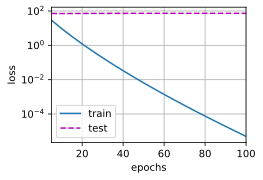

In [6]:
train(lambd=0)

### [**使用权重衰减**]

下面，我们使用权重衰减来运行代码。注意，在这里训练误差增大，但测试误差减小。这正是我们期望从正则化中得到的效果。


w的L2范数是： 0.3866170048713684


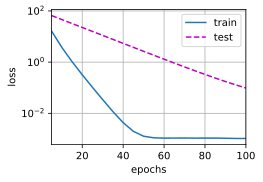

In [7]:
train(lambd=3)

## [**简洁实现**]

由于权重衰减在神经网络优化中很常用，深度学习框架为了便于使用权重衰减，便将权重衰减集成到优化算法中，以便与任何损失函数结合使用。此外，这种集成还有计算上的好处，允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。由于更新的权重衰减部分仅依赖于每个参数的当前值，因此优化器必须至少接触每个参数一次。


在下面的代码中，我们在实例化优化器时直接通过`weight_decay`指定weight decay超参数。默认情况下，PyTorch同时衰减权重和偏移。这里我们只为权重设置了`weight_decay`，所以bias参数$b$不会衰减。


In [8]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss()
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减。
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with torch.enable_grad():
                trainer.zero_grad()
                l = loss(net(X), y)
            l.backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

[**这些图看起来和我们从零开始实现权重衰减时的图相同**]。然而，它们运行得更快，更容易实现，对于更复杂的问题，这一好处将变得更加明显。


w的L2范数： 12.702032089233398


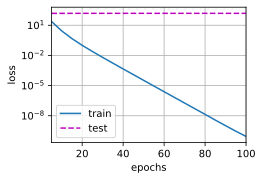

In [9]:
train_concise(0)

w的L2范数： 0.3674013614654541


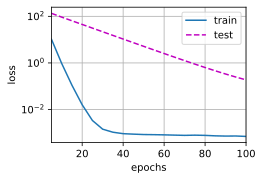

In [10]:
train_concise(3)

到目前为止，我们只接触到一个简单线性函数的概念。此外，由什么构成一个简单的非线性函数可能是一个更复杂的问题。例如，[再生核希尔伯特空间（RKHS）](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)允许在非线性环境中应用为线性函数引入的工具。不幸的是，基于RKHS的算法往往难以扩展到大型、高维的数据。在这本书中，我们将默认使用简单的启发式方法，即在深层网络的所有层上应用权重衰减。

## 小结

* 正则化是处理过拟合的常用方法。在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。
* 保持模型简单的一个特别的选择是使用$L_2$惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。
* 权重衰减功能在深度学习框架的优化器中提供。
* 在同一训练代码实现中，不同的参数集可以有不同的更新行为。

## 练习

1. 在本节的估计问题中使用$\lambda$的值进行实验。绘制训练和测试准确率关于$\lambda$的函数。你观察到了什么？
1. 使用验证集来找到最佳值$\lambda$。它真的是最优值吗？这有关系吗？
1. 如果我们使用$\sum_i |w_i|$作为我们选择的惩罚（$L_1$正则化），那么更新方程会是什么样子？
1. 我们知道$\|\mathbf{w}\|^2 = \mathbf{w}^\top \mathbf{w}$。你能找到类似的矩阵方程吗（见 :numref:`subsec_lin-algebra-norms` 中的弗罗贝尼乌斯范数）？
1. 回顾训练误差和泛化误差之间的关系。除了权重衰减、增加训练数据、使用适当复杂度的模型之外，你还能想出其他什么方法来处理过拟合？
1. 在贝叶斯统计中，我们使用先验和似然的乘积，通过公式$P(w \mid x) \propto P(x \mid w) P(w)$得到后验。如何得到带正则化的$P(w)$？


[Discussions](https://discuss.d2l.ai/t/1808)
